# Тема 11. Критерии хи-квадрат и отношения правдоподобий для дискретных данных

In [1]:
import numpy as np
import pandas as pd
import math as mt
import scipy.stats as st
import scipy.optimize as opt
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import namedtuple
from tqdm import tqdm

### 1 Задание

In [7]:
with open("pi_places.txt") as f:
    places = np.fromiter(map(int, f.read()), np.int32)

cnt = np.bincount(places)
res = st.chisquare(cnt)
print(res.pvalue)
print(places[98:102])

0.8828093219851211
[7 9 8 2]


### 2 Задание

In [3]:
df = pd.read_csv('../02-DataFrame/Priem.csv', encoding='utf-8')
score_columns = ['Сумма.баллов', 'ЕГЭ...матем.', 'ЕГЭ...рус.яз.']
df = df.dropna()
df = df.astype({c: 'int32' for c in score_columns})
df.head(1)

,Пол,Сумма.баллов,ЕГЭ...матем.,ЕГЭ...рус.яз.,Аттестат.с.отличием.оценка,ГТО.оценка,Сочинение.оценка,Регион,Тип.насел..пункта,Дата.рождения,День.рождения,Месяц.рождения
0,МУЖСКОЙ,388,90,98,5,0,1,Красноярский край,ГОРОД,24.09.1998,24,9


In [83]:
factor_columns = ['Пол', 'Аттестат.с.отличием.оценка', 'ГТО.оценка']
data = df[[*score_columns, *factor_columns]].copy()
score_group_columns = [sc + ".group" for sc in score_columns]
for sc, sgc in zip(score_columns, score_group_columns):
    k = 5
    min_score = data[sc].min()
    data[sgc] = (data[sc] - min_score) // k

for factor in factor_columns:
    print(f"Фактор: {factor}")
    for sc, sgc in zip(score_columns, score_group_columns):
        obs = pd.crosstab(data[factor], data[sgc])
        res = st.chi2_contingency(obs)
        print(f"\t{sc}: p-value = {res.pvalue}")

Фактор: Пол
	Сумма.баллов: p-value = 0.9168068194349944
	ЕГЭ...матем.: p-value = 0.8369195545064003
	ЕГЭ...рус.яз.: p-value = 2.6821410507638917e-14
Фактор: Аттестат.с.отличием.оценка
	Сумма.баллов: p-value = 1.9472625623204327e-05
	ЕГЭ...матем.: p-value = 0.07112030142533038
	ЕГЭ...рус.яз.: p-value = 1.351409730993612e-27
Фактор: ГТО.оценка
	Сумма.баллов: p-value = 0.4264780960735666
	ЕГЭ...матем.: p-value = 0.30923679553476124
	ЕГЭ...рус.яз.: p-value = 0.581885241600965


In [84]:
obs = pd.crosstab(data['ЕГЭ...матем..group'], data['ЕГЭ...рус.яз..group'])
res = st.chi2_contingency(obs)
print(f"p-value = {res.pvalue}")

p-value = 3.8297255158463534e-10


### 3 Задание

Cressie-Read power divergence statistic:

$$ \frac{2}{\lambda(\lambda+1)} \sum_{i=1}^{k}\nu_i \left( \left( \frac{\nu_i}{np_i}\right) ^\lambda - 1 \right) $$

$$ \lambda = 0: \qquad 2\sum_{i=1}^{k}\nu_i \ln{\frac{\nu_i}{np_i}} $$

$$ \lambda = -1: \qquad 2\sum_{i=1}^{k}np_i \ln{\frac{np_i}{\nu_i}} $$

In [4]:
n_categories = 5
p_uni = np.full(n_categories, 1/n_categories)
p = np.random.dirichlet(np.ones(n_categories), size=1).reshape(-1)
p

array([0.26695755, 0.16491493, 0.12825619, 0.13105065, 0.30882067])

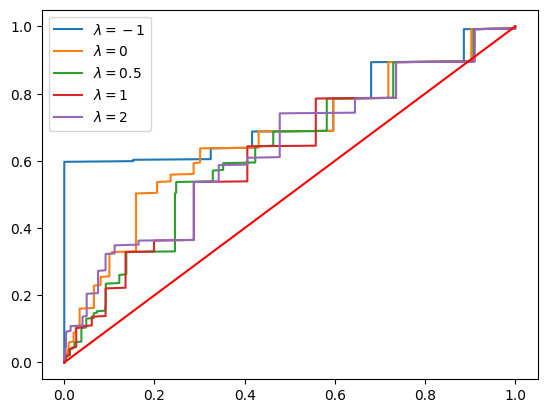

In [7]:
n_trials = 10
p_act = p
p_exp = p_uni
rv = st.multinomial(n=n_trials, p=p_act)

k = 500
sample = rv.rvs(size=k)

x = np.linspace(0, 1, k)

for a in (-1, 0, 0.5, 1, 2):
    stat, p_value = st.power_divergence(sample, f_exp=n_trials*p_exp, axis=1, lambda_=a)
    p_value = np.sort(p_value)
    plt.plot(p_value, x, label=fr"$\lambda = {a}$")
plt.plot(x, x, c='r')
plt.legend();